In [14]:
# lib and settings for interactive plots
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)
    # figsize=(5, 4)
import matplotlib.pyplot as plt

import numpy as np
import math
import pandas as pd
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import layers
import keras.callbacks

from itertools import product
import os
base_folder = os.path.join(os.getcwd())
base_folder = os.path.join('..')

from tqdm import tqdm

grid_path = os.path.join(base_folder, 'Data', 'grid')
params = {
        'run': 30,
        'sigma': [0.3, 0.4, 0.5, 0.6],
        'theta': [0.01, 0.1, 0.5, 3],
        'mu': [0.1, 1, 10, 24],
        'delta': [0.01,0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
        'N': 1000
    }
F_OVERRIDE_GRID = True
F_DETERMINISTIC_ONLY = False

In [2]:
def milstein_method(theta, sigma, mu, delta_t, x0=1, N=1000, deterministic_only=False):
    # TODO: check parameter mu
    X = np.zeros(N)
    X[0] = x0
    W = np.random.normal(0, 1, size=N)
    W[0] = 0
    for i in range(N-1):
        if deterministic_only:
            X[i+1] = X[i] + theta*(mu - X[i])*delta_t 
        else:
            X[i+1] = X[i] + theta*(mu - X[i])*delta_t + sigma*W[i]*X[i]*np.sqrt(delta_t) + 0.5*(sigma**2)*X[i]*delta_t*(W[i]**2 - 1)
    return X

In [15]:
if not(os.path.exists(grid_path+'.npy')) or F_OVERRIDE_GRID:
    grid = np.zeros((params['run'], 
                    len(params['sigma']),
                    len(params['theta']),
                    len(params['mu']),
                    len(params['delta']),
                    params['N']))
    for r in tqdm(range(params['run'])):
        for s, t, m, d in product(params['sigma'], params['theta'], params['mu'], params['delta']):
            # TODO: just in case add also mu 
            si = params['sigma'].index(s)
            ti = params['theta'].index(t)
            di = params['delta'].index(d)
            mi = params['mu'].index(m)
            grid[r,si,ti,mi,di,:] = milstein_method(t,s,m,d, deterministic_only=F_DETERMINISTIC_ONLY)
    # store grid data
    np.save(grid_path, grid, allow_pickle=True)
grid = np.load(grid_path+'.npy', allow_pickle=True)

100%|██████████| 30/30 [00:41<00:00,  1.37s/it]


In [4]:
def plot_datapoints(grid, params, run=0, sigma=0.5, theta=0.1, mu=1, delta=0.2, variation=None, num_run=10):
    assert run in range(params['run'])
    assert variation in list(params.keys())+[None]
    # TODO: prepare labels in function of different parameters in order to plot also the plot legend
    sigma = params['sigma'].index(sigma)
    theta = params['theta'].index(theta)
    mu = params['mu'].index(mu)
    delta = params['delta'].index(delta)
    plt.figure(figsize=figsize)
    if variation is None:
        Xs = grid[run, sigma, theta, delta, :]
        plt.plot(Xs)
    else:
        if variation == 'theta':
            Xs = grid[run, sigma, :, mu, delta, :]
        elif variation == 'sigma':
            Xs = grid[run, :, theta, mu, delta, :]
        elif variation == 'mu':
            Xs = grid[run, sigma, theta, :, delta, :]
        elif variation == 'delta':
            Xs = grid[run, sigma, theta, :, mu, :]
        elif variation == 'run':
            Xs = grid[:num_run, sigma, theta, mu, delta, :]
        labels = [variation+' = '+str(p) for p in params[variation]]
        for X, l in zip(Xs, labels):
            plt.plot(X, label = l)
    plt.xlabel('t')
    plt.ylabel('X(t)')
    plt.legend()
    plt.show()

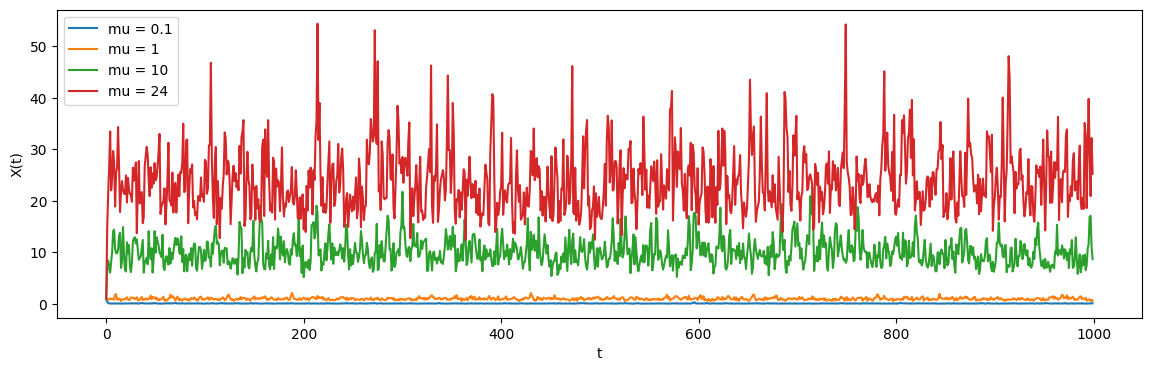

In [21]:
run = 1
mu = 10
sigma = 0.5
theta = 3
delta = 0.2
best_index_greed = (run, params['sigma'].index(sigma), params['theta'].index(theta), params['mu'].index(mu), params['delta'].index(delta))
#
plot_datapoints(grid, params, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, variation='mu')
# plot_datapoints(grid, params, run=run, variation='mu')

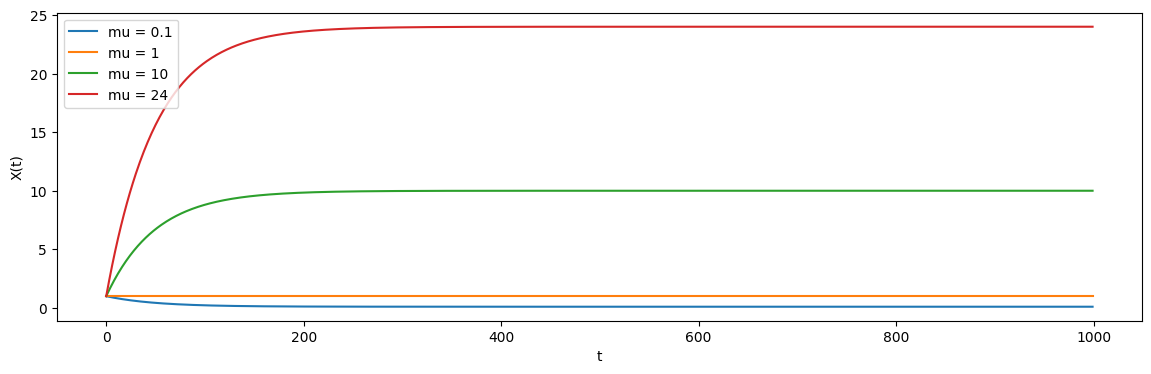

In [8]:
run = 0
mu = 10
sigma = 0.5
theta = 0.1
delta = 0.2
best_index_greed = (run, params['sigma'].index(sigma), params['theta'].index(theta), params['mu'].index(mu), params['delta'].index(delta))
#
plot_datapoints(grid_det, params, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, variation='mu')
# plot_datapoints(grid, params, run=run, variation='mu')

* theta modula le curve per farle arrivare al punto di equilibrio mu. se theta > 1 arriva velocemente al punto di equilibrio, se invece 0< theta < 1 allora ci arriva lentamente

* se si considera solo la componenete deterministica, dimenticando la parte stocastica, allora si apprezza l'effetto di mu

* dunque va modificata la formula per arrivare a questo effetto

* notare che nel caso in cui si consideri anche la componente stocastica della SDE si osserva una maggiore ampiezza delle frequenze per valori di mu alti, e minori ampiezze nel caso opposto

$\Rightarrow$ mi aspetto che la threshold debba essere in funzione di mu

0.15000000000000002


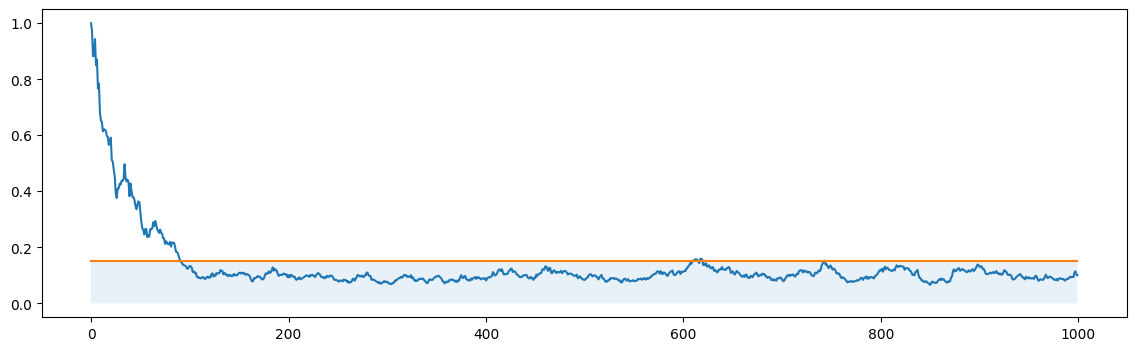

In [61]:
plt.figure(figsize=figsize)

run = 0
mu = 10
sigma = 0.5
theta = 3
delta = 0.2
# threshold = (lmbda(sigma, theta) * mu) / (lmbda(sigma, theta) +2)
# threshold = mu * (1 + sigma + sigma**2)
threshold = mu * (1 + sigma)
# threshold = mu
print(threshold)

best_index_greed = (run, params['sigma'].index(sigma), params['theta'].index(theta), params['mu'].index(mu), params['delta'].index(delta))


Xtest = grid[run, best_index_greed[1], best_index_greed[2], best_index_greed[3], best_index_greed[3], :]

plt.plot(Xtest, label='run0')
plt.plot([threshold for _ in range(params['N'])] , label='treshold')
# plt.plot(threshold_mm(theta, sigma, mu, delta), label='treshold linear')
plt.fill_between(list(range(params['N'])),
                 [threshold for _ in range(params['N'])],
                 [0 for _ in range(params['N'])], alpha=0.1)